In [2]:
%matplotlib inline
import d2lzh as d2l
from mxnet import autograd, contrib, gluon, image, init, nd
from mxnet.gluon import loss as gloss, nn
import time

# 类别预测层
def cls_predictor(num_anchors, num_classes):
    return nn.Conv2D(num_anchors * (num_classes + 1), kernel_size=3,
                     padding=1)

In [3]:
# 边框预测层， 每个锚框4个偏移量
def bbox_predictor(num_anchors):
    return nn.Conv2D(num_anchors * 4, kernel_size=3, padding=1)

In [4]:
def forward(x, block):
    block.initialize()
    return block(x)

Y1 = forward(nd.zeros((2, 8, 20, 20)), cls_predictor(5, 10))
Y2 = forward(nd.zeros((2, 16, 10, 10)), cls_predictor(3, 10))
(Y1.shape, Y2.shape)

((2, 55, 20, 20), (2, 33, 10, 10))

In [5]:
def flatten_pred(pred):
    return pred.transpose((0, 2, 3, 1)).flatten()

# 将预测结果转化为(批量大小, 高 × 宽 × 通道数)
# 之后在维度1上连结
def concat_preds(preds):
    return nd.concat(*[flatten_pred(p) for p in preds], dim=1)

In [6]:
concat_preds([Y1, Y2]).shape

(2, 25300)

In [7]:
def down_sample_blk(num_channels):
    blk = nn.Sequential()
    for _ in range(2):
        blk.add(nn.Conv2D(num_channels, kernel_size=3, padding=1),
                nn.BatchNorm(in_channels=num_channels), # 批量归一化
                nn.Activation('relu'))
    blk.add(nn.MaxPool2D(2))
    return blk

In [8]:
forward(nd.zeros((2, 3, 20, 20)), down_sample_blk(10)).shape

(2, 10, 10, 10)

In [9]:
# 基础网络块用来从原始图像中抽取特征。
# 该网络串联3个高和宽减半块，并逐步将通道数翻倍。
def base_net():
    blk = nn.Sequential()
    for num_filters in [16, 32, 64]:
        blk.add(down_sample_blk(num_filters))
    return blk

forward(nd.zeros((2, 3, 256, 256)), base_net()).shape

(2, 64, 32, 32)

In [10]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 4:
        blk = nn.GlobalMaxPool2D()
    else:
        blk = down_sample_blk(128)
    return blk

In [11]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    # 生成锚框
    anchors = contrib.ndarray.MultiBoxPrior(Y, sizes=size, ratios=ratio)
    # 预测类别
    cls_preds = cls_predictor(Y)
    # 预测偏移量
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

In [12]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1
num_anchors

4

In [13]:
class TinySSD(nn.Block):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        for i in range(5):
            # 即赋值语句self.blk_i = get_blk(i)
            setattr(self, 'blk_%d' % i, get_blk(i))
            setattr(self, 'cls_%d' % i, cls_predictor(num_anchors,num_classes))
            setattr(self, 'bbox_%d' % i, bbox_predictor(num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # getattr(self, 'blk_%d' % i)即访问self.blk_i
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(X,getattr(self, 'blk_%d' % i), 
                                                                     sizes[i], ratios[i],
                                                                     getattr(self, 'cls_%d' % i), getattr(self, 'bbox_%d' % i))
#         print(nd.concat(*anchors, dim=1))
        # reshape函数中的0表示保持批量大小不变
        return (nd.concat(*anchors, dim=1),
                concat_preds(cls_preds).reshape((0, -1, self.num_classes + 1)), 
                concat_preds(bbox_preds))

In [14]:
net = TinySSD(num_classes=1)
net.initialize()
X = nd.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: (1, 5444, 4)
output class preds: (32, 5444, 2)
output bbox preds: (32, 21776)


In [15]:
batch_size = 32
train_iter, _ = d2l.load_data_pikachu(batch_size)

In [16]:
ctx, net = d2l.try_gpu(), TinySSD(num_classes=1)
net.initialize(init=init.Xavier(), ctx=ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd',
                        {'learning_rate': 0.2, 'wd': 5e-4})

In [28]:
# 有关锚框类别的损失，交叉熵损失函数
cls_loss = gloss.SoftmaxCrossEntropyLoss()
# 正类锚框偏移量的损失，L1 范数损失，即预测值与真实值之间差的绝对值。
# bbox_loss = gloss.L1Loss()
def focal_loss(gamma, x):
    return -(1 - x) ** gamma * x.log()
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(axis=1, keepdims=True)
    return X_exp / partition 
def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    cls = cls_loss(cls_preds, cls_labels)
    cls = focal_loss(1.0 , (-cls).exp())
#     print(cls)
    # bbox = bbox_loss(bbox_preds * bbox_masks, bbox_labels * bbox_masks)
    bbox = nd.smooth_l1(bbox_preds * bbox_masks - bbox_labels * bbox_masks, scale=0.3).mean(axis=1)
#     print(cls)
#     print(bbox)
    return cls + bbox

In [18]:
# 沿用准确率评价分类结果
def cls_eval(cls_preds, cls_labels):
    # 由于类别预测结果放在最后一维，argmax需要指定最后一维
    return (cls_preds.argmax(axis=-1) == cls_labels).sum().asscalar()

# L1 范数损失，我们用平均绝对误差评价边界框的预测结果。
def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return ((bbox_labels - bbox_preds) * bbox_masks).abs().sum().asscalar()

In [29]:
for epoch in range(20):
    acc_sum, mae_sum, n, m = 0.0, 0.0, 0, 0
    train_iter.reset()  # 从头读取数据
    start = time.time()
    for batch in train_iter:
        X = batch.data[0].as_in_context(ctx)
        Y = batch.label[0].as_in_context(ctx)
        with autograd.record():
            # 生成多尺度的锚框，为每个锚框预测类别和偏移量
            anchors, cls_preds, bbox_preds = net(X)
            # 为每个锚框标注类别和偏移量
            bbox_labels, bbox_masks, cls_labels = contrib.nd.MultiBoxTarget(
                anchors, Y, cls_preds.transpose((0, 2, 1)))
            # 根据类别和偏移量的预测和标注值计算损失函数
            l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                          bbox_masks)
        l.backward()
        trainer.step(batch_size)
        acc_sum += cls_eval(cls_preds, cls_labels)
        n += cls_labels.size
        mae_sum += bbox_eval(bbox_preds, bbox_labels, bbox_masks)
        m += bbox_labels.size

    if (epoch + 1) % 5 == 0:
        print('epoch %2d, class err %.2e, bbox mae %.2e, time %.1f sec' % (
            epoch + 1, 1 - acc_sum / n, mae_sum / m, time.time() - start))

epoch  5, class err 3.17e-03, bbox mae 3.43e-03, time 12.9 sec
epoch 10, class err 3.14e-03, bbox mae 3.38e-03, time 13.0 sec
epoch 15, class err 3.14e-03, bbox mae 3.40e-03, time 13.6 sec
epoch 20, class err 3.25e-03, bbox mae 3.50e-03, time 13.0 sec


In [25]:
img = image.imread('../img/pikachu.jpg')
feature = image.imresize(img, 256, 256).astype('float32')
X = feature.transpose((2, 0, 1)).expand_dims(axis=0)
X


[[[[178. 173. 170. ... 173. 151. 145.]
   [189. 180. 181. ... 159. 141. 144.]
   [204. 188. 199. ... 162. 151. 141.]
   ...
   [103. 105. 112. ... 113. 116. 121.]
   [101. 103. 106. ... 103. 119. 117.]
   [106. 107. 106. ... 118. 127. 129.]]

  [[179. 174. 172. ... 165. 147. 143.]
   [190. 181. 182. ... 151. 138. 142.]
   [203. 188. 200. ... 157. 148. 139.]
   ...
   [ 88.  90.  97. ...  92.  94.  98.]
   [ 86.  87.  90. ...  82.  98.  95.]
   [ 89.  90.  89. ...  99. 106. 108.]]

  [[201. 198. 197. ... 181. 165. 164.]
   [211. 202. 204. ... 167. 156. 163.]
   [220. 205. 219. ... 170. 167. 163.]
   ...
   [ 81.  83.  90. ...  74.  72.  75.]
   [ 79.  80.  83. ...  66.  78.  72.]
   [ 82.  83.  81. ...  83.  86.  84.]]]]
<NDArray 1x3x256x256 @cpu(0)>

In [26]:
def predict(X):
    anchors, cls_preds, bbox_preds = net(X.as_in_context(ctx))
    # 转化为类别预测概率[0,1]
    cls_probs = cls_preds.softmax().transpose((0, 2, 1))
    output = contrib.nd.MultiBoxDetection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0].asscalar() != -1]
#     print(idx)
#     print(output)
#     print(output[0,4])
    return output[0, idx]

output = predict(X)
# sizes = nd.array([[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
#          [0.88, 0.961]])
# sizes[0,[0,1,2,3]]

MXNetError: [14:45:57] C:\Jenkins\workspace\mxnet-tag\mxnet\src\c_api\c_api.cc:477: Check failed: arr->shape().Size() > 0 (0 vs. 0) : Source ndarray's shape is undefined. Input shape: [0]

In [ ]:
d2l.set_figsize((5, 5))

def display(img, output, threshold):
    fig = d2l.plt.imshow(img.asnumpy())
    for row in output:
        score = row[1].asscalar()
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * nd.array((w, h, w, h), ctx=row.context)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(img, output, threshold=0.3)

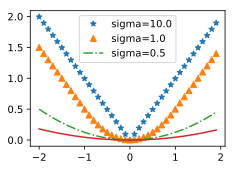

In [74]:
sigmas = [10, 1, 0.5]
lines = ['*', '^', '-.']
x = nd.arange(-2, 2, 0.1)
d2l.set_figsize()

for l, s in zip(lines, sigmas):
    y = nd.smooth_l1(x, scalar=s)
    d2l.plt.plot(x.asnumpy(), y.asnumpy(), l, label='sigma=%.1f' % s)
d2l.plt.legend();

y = nd.smooth_l1(x, scalar=0.3)
d2l.plt.plot(x.asnumpy(), y.asnumpy(), '-')
d2l.plt.legend();

2423